# Importing all libraries

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import SGDRegressor 
from sklearn.model_selection import RandomizedSearchCV 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skimage import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score,learning_curve, ShuffleSplit, validation_curve
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

In [2]:
# Loading the file directories
special = os.listdir(r'C:\Users\hritv\Desktop\Fall 22\ML final proj\special_CSV')
open_box= os.listdir(r'C:\Users\hritv\Desktop\Fall 22\ML final proj\Open_Box_CSV_files')
corridor= os.listdir(r'C:\Users\hritv\Desktop\Fall 22\ML final proj\special_CSV')
test= os.listdir(r'C:\Users\hritv\Desktop\Fall 22\ML final proj\drive-download-20221209T231529Z-001')

# Data pre-processing

In [3]:
# data extraction and dataframes preparation
def df_concatenation(dfs):
    DF= pd.DataFrame()
    for i in dfs:
        df_temp= pd.read_csv(i, header=None)
        DF= pd.concat([DF,df_temp], axis=0, ignore_index=True)
    return DF
special_df= df_concatenation(special)
open_box_df= df_concatenation(open_box)
corridor_df= df_concatenation(corridor)
test_df= df_concatenation(test)
init= []
for i in range(1,55):
    coln= 'Laser'+str(i)
    init.append(coln)
rest= ['Final_goal_x','Final_goal_y','Final_goal_qr','Final_goal_qk','Local_goal_x','Local_goal_y','Local_goal_qr','Local_goal_qk','Robot_pos_x','Robot_pos_y','Robot_pos_qr','Robot_pos_qk','Cmd_vel_v','Cmd_vel_w']
for name in rest:
    init.append(name)
col_names= init
data_df= pd.concat([special_df,open_box_df,corridor_df], axis=0, ignore_index=True)

# Feature selection
def angle_mean_data(df,one_scan_deg):
    new_df= pd.DataFrame()
    for i in range(len(df.iloc[:,:1081].columns)):
        if i%one_scan_deg != 0:
            pass
        else:
            add= df.iloc[:,i-one_scan_deg:i].mean(axis=1)
            new_df= pd.concat([new_df,add], axis=1, ignore_index= True)
    new_df.drop(0,axis=1, inplace= True)
    new_data= pd.concat([new_df,df.iloc[:,1080:]], axis=1)
    new_data.columns= col_names
    df.insert(loc=56, column='Final_goal_q', value= (new_data['Final_goal_qr'] + new_data['Final_goal_qk']))
    df.insert(loc=59, column='Local_goal_q', value= (new_data['Local_goal_qr'] + new_data['Local_goal_qk']))
    df.insert(loc=62, column='Robot_pos_q', value= (new_data['Robot_pos_qr'] + new_data['Robot_pos_qk']))
    new_data.drop(['Final_goal_qr','Final_goal_qk'], axis=1,inplace=True)
    new_data.drop(['Local_goal_qr','Local_goal_qk'], axis=1,inplace=True)
    new_data.drop(['Robot_pos_qr','Robot_pos_qk'], axis=1,inplace=True)
    new_data.dropna(inplace= True)
    return new_data
train_data= angle_mean_data(data_df,20)
test_data= angle_mean_data(test_df,20)

In [4]:
# Creating functions for hyperparameters, learning and validation curves

def hyper_parameter_tuning(model_type, X_train, Y_train):
    clf = RandomizedSearchCV(estimator=model_type["estimator"],param_distributions=model_type["parameter"],cv=2,n_jobs=-1,verbose=1,n_iter= 20)
    clf.fit(X_train, Y_train)
    return [clf.best_estimator_, clf.best_params_]

def plot_curve_learning(estimator, X, y, title, train_sizes=np.linspace(0.1, 1.0, 10)):
    cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
    train_set_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator,X,y,scoring="r2",cv=cv,n_jobs=-1,train_sizes=train_sizes,return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("R2 Score")
    plt.grid()
    plt.plot(train_set_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_set_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_curve_validation_lr(m,estimator,param, X, y, title,train_sizes=np.linspace(0.1, 1.0, 10)):
    cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
    for i in param.keys():
        train_scores, test_scores = validation_curve(estimator,X,y,cv=cv,param_name= i, param_range= m['parameter'][i]) 
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.grid()
        plt.plot(m['parameter'][i], train_scores_mean,
                 marker='o', markersize=5,
                 color='blue', label='Training score')
        plt.plot(m['parameter'][i], test_scores_mean,
                 marker='o', markersize=5,
                 color='green', label='Cross-validation score')
        plt.xlabel('Parameter '+i)
        plt.ylabel('R2 score')
        plt.show()
        
def plot_curve_validation_nn(m,estimator,param, X, y, title,train_sizes=np.linspace(0.1, 1.0, 10)):
    cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
    for i in param.keys():
        if i!= 'mlpregressor__hidden_layer_sizes':
            train_scores, test_scores = validation_curve(estimator,X,y,cv=cv,param_name= i, param_range= m['parameter'][i]) 
            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            plt.grid()
            plt.plot(m['parameter'][i], train_scores_mean,
                     marker='o', markersize=5,
                     color='blue', label='Training score')
            plt.plot(m['parameter'][i], test_scores_mean,
                     marker='o', markersize=5,
                     color='green', label='Cross-validation score')
            plt.xlabel('Parameter '+i)
            plt.ylabel('R2 score')
            plt.show()
        else:
            continue
        
def plot_curve_validation_svm(m,estimator,param, X, y, title,train_sizes=np.linspace(0.1, 1.0, 10)):
    cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
    if param['multioutputregressor__estimator__kernel'] == 'rbf':
        for i in param.keys():
            train_scores, test_scores = validation_curve(estimator,X,y,cv=cv,param_name= i, param_range=m['parameter'][0][i]) 
            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            plt.grid()
            plt.plot(m['parameter'][0][i], train_scores_mean,
                     marker='o', markersize=5,
                     color='blue', label='Training score')
            plt.plot(m['parameter'][0][i], test_scores_mean,
                     marker='o', markersize=5,
                     color='green', label='Cross-validation score')
            plt.xlabel('Parameter '+i)
            plt.ylabel('R2 score')
            plt.show()
    else:
        for i in param.keys():
            train_scores, test_scores = validation_curve(estimator,X,y,cv=cv,param_name= i, param_range=m['parameter'][1][i]) 
            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            plt.grid()
            plt.plot(m['parameter'][1][i], train_scores_mean,
                     marker='o', markersize=5,
                     color='blue', label='Training score')
            plt.plot(m['parameter'][1][i], test_scores_mean,
                     marker='o', markersize=5,
                     color='green', label='Cross-validation score')
            plt.xlabel('Parameter '+i)
            plt.ylabel('R2 score')
            plt.show()

# SGD Regressor model

In [11]:
X_train= train_data.drop(['Cmd_vel_v','Cmd_vel_w'], axis=1)
y_train= train_data[['Cmd_vel_v','Cmd_vel_w']]

Fitting 2 folds for each of 20 candidates, totalling 40 fits


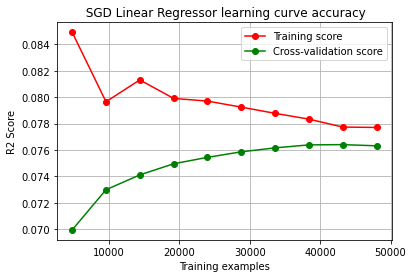

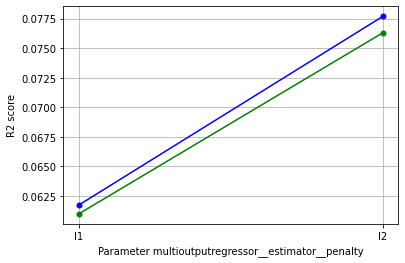

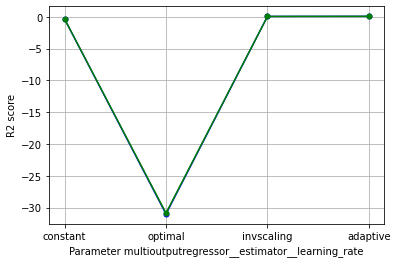

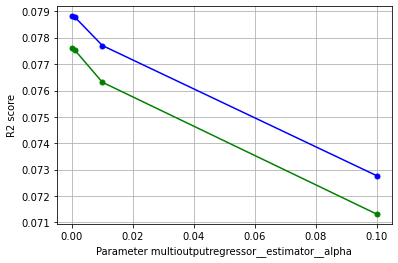


LR: 
	Optimal Hyper-parameters: {'multioutputregressor__estimator__penalty': 'l2', 'multioutputregressor__estimator__learning_rate': 'adaptive', 'multioutputregressor__estimator__alpha': 0.01} 
	scores: [0.06114418 0.06312714] 
	mean score: 0.06213565860002873


[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('multioutputregressor',
                  MultiOutputRegressor(estimator=SGDRegressor(alpha=0.01,
                                                              learning_rate='adaptive',
                                                              max_iter=10000)))]),
 0.06213565860002873]

In [10]:
def best_LR(X_train, Y_train):
    model = dict(estimator= make_pipeline(StandardScaler(),MultiOutputRegressor(estimator= SGDRegressor(max_iter= 10000))),
    parameter={
    #loss = ['squared_error', 'epsilon_insensitive','squared_epsilon_insensitive'],
    "multioutputregressor__estimator__penalty" : ['l1', 'l2'], 
    "multioutputregressor__estimator__alpha" : [0.0001, 0.001, 0.01, 0.1], 
    "multioutputregressor__estimator__learning_rate" : ['constant', 'optimal', 'invscaling', 'adaptive'], 
    #eta0 = [1, 10, 100] 
    })
    [estimator, params] = hyper_parameter_tuning(model, X_train, Y_train)
    plot_curve_learning(estimator, X_train, Y_train, " SGD Linear Regressor learning curve accuracy")
    plot_curve_validation_lr(model,estimator,params, X_train, Y_train, " SGD Linear Regressor validation curve accuracy")
    cv_results = cross_val_score(estimator, X_train, Y_train, cv=2, scoring='r2')
    print(f'\nLR: \n\tOptimal Hyper-parameters: {params} \n\tscores: {cv_results} \n\tmean score: {cv_results.mean()}')
    return [estimator, cv_results.mean()]
best_LR(X_train,y_train)

# SVM model

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 15 candidates, totalling 30 fits


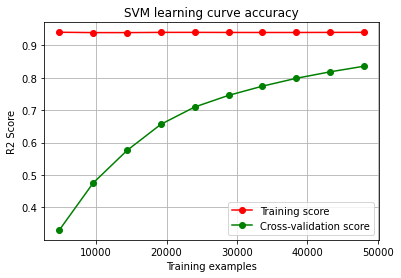

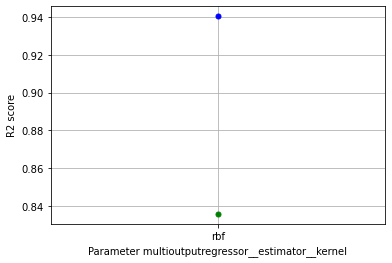

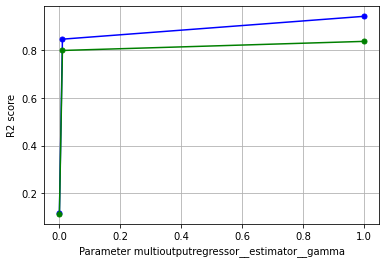

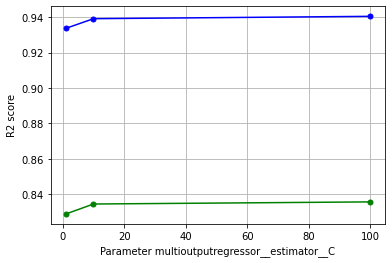


SVM: 
	Optimal Hyper-parameters: {'multioutputregressor__estimator__kernel': 'rbf', 'multioutputregressor__estimator__gamma': 1, 'multioutputregressor__estimator__C': 100} 
	scores: [0.73599831 0.70817686] 
	mean score: 0.7220875816047061


[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('multioutputregressor',
                  MultiOutputRegressor(estimator=SVR(C=100, cache_size=1000,
                                                     gamma=1)))]),
 0.7220875816047061]

In [15]:
def best_SVM(X_train, Y_train):
    model = dict(estimator= make_pipeline(StandardScaler(),MultiOutputRegressor(estimator=SVR(cache_size=1000))),
    parameter=[{
    'multioutputregressor__estimator__C': [1, 10, 100],
    'multioutputregressor__estimator__gamma': [0.0001, 0.01, 1],
    'multioutputregressor__estimator__kernel': ['rbf']
    },
    {
    'multioutputregressor__estimator__C': [1, 10, 100],
    'multioutputregressor__estimator__degree': [1, 2],
    'multioutputregressor__estimator__kernel': ['poly']
    }])
    [estimator, params] = hyper_parameter_tuning(model, X_train, Y_train)
    plot_curve_learning(estimator, X_train, Y_train, "SVM learning curve accuracy")
    plot_curve_validation_svm(model,estimator,params, X_train, Y_train, " SGD Linear Regressor validation curve accuracy")
    cv_results = cross_val_score(estimator, X_train, Y_train, cv=2, scoring='r2')
    print(f'\nSVM: \n\tOptimal Hyper-parameters: {params} \n\tscores: {cv_results} \n\tmean score: {cv_results.mean()}')
    return [estimator, cv_results.mean()]

best_SVM(X_train,y_train)

# Neural Network

In [9]:
X_train_nn= train_data.drop(['Cmd_vel_v','Cmd_vel_w'], axis=1)
y_train_nn= train_data[['Cmd_vel_v','Cmd_vel_w']]

Fitting 2 folds for each of 20 candidates, totalling 40 fits


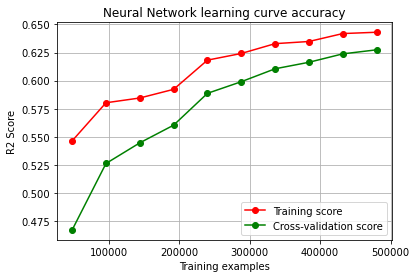

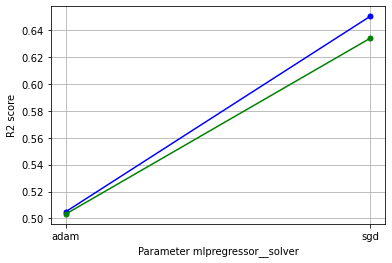

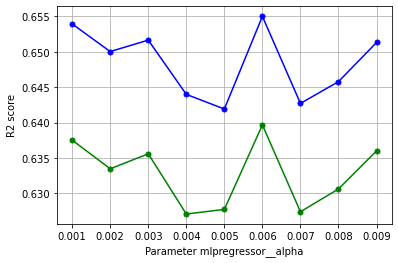

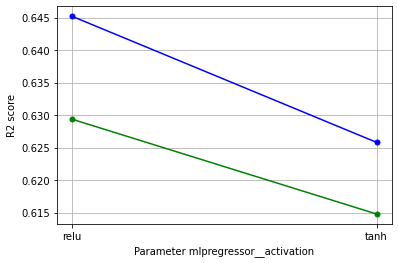


NN: 
	Optimal Hyper-parameters: {'mlpregressor__solver': 'sgd', 'mlpregressor__hidden_layer_sizes': (77, 77, 77), 'mlpregressor__alpha': 0.002, 'mlpregressor__activation': 'relu'} 
	scores: [0.51787369 0.52232602] 
	mean score: 0.5200998560333945


[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('mlpregressor',
                  MLPRegressor(alpha=0.002, hidden_layer_sizes=(77, 77, 77),
                               learning_rate_init=0.01, solver='sgd'))]),
 0.5200998560333945]

In [10]:
def best_NN(X_train, Y_train, kfold):
    model = dict(estimator= make_pipeline(StandardScaler(),MLPRegressor(learning_rate_init= 0.01)),
    parameter={
    'mlpregressor__solver': ['adam','sgd'],
    'mlpregressor__activation': ['relu','tanh'],
    'mlpregressor__alpha': np.concatenate(
            (
            np.arange(0.001,0.01,0.001),
            np.arange(0.01,0.01,0.01),
            np.arange(0.1,0.1,0.1)
            )
        ),
        'mlpregressor__hidden_layer_sizes':
            [(i,) for i in np.arange(5,100,1)]+
            [(i,i,) for i in np.arange(5,100,1)]+
            [(i,i,i) for i in np.arange(5,100,1)],
    })
    [estimator, params] = hyper_parameter_tuning(model, X_train, Y_train)
    plot_curve_learning(estimator, X_train, Y_train, "Neural Network learning curve accuracy")
    plot_curve_validation_nn(model,estimator,params, X_train, Y_train, " Neural Network validation curve accuracy")
    cv_results = cross_val_score(estimator, X_train, Y_train, cv=kfold, scoring='r2')
    print(f'\nNN: \n\tOptimal Hyper-parameters: {params} \n\tscores: {cv_results} \n\tmean score: {cv_results.mean()}')
    return [estimator, cv_results.mean()]

best_NN(X_train_nn, y_train_nn, 2)

# Testing model

In [12]:
# Splitting test data into X_test and Y_test
test_data= test_data.sample(frac=1).reset_index(drop=True)
X_test= test_data.iloc[:80000].drop(['Cmd_vel_v','Cmd_vel_w'], axis=1)
y_test= test_data.iloc[:80000][['Cmd_vel_v','Cmd_vel_w']]

In [ ]:
# Model testing
test_model= make_pipeline(StandardScaler(),MultiOutputRegressor(estimator=SVR(kernel= 'rbf', gamma=1, C=100, cache_size=1000)))
test_model.fit(X_test, y_test)
y_pred = test_model.predict(X_test)
score= test_model.score(X_test,y_test)
print('E_test : ',1- score)

In [11]:
# Calculating E_out
def E_out(score,N,confidence):
    a= 1-score
    b= np.sqrt((1/(2*N)* np.log(2/confidence)))
    return a+b
E_out(score,len(X_test),0.1)

0.08006603645800807